In [1]:
import sys
sys.dont_write_bytecode = True
sys.path.append("../scripts")
import scraper
import pickle
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
# Make a list of all GHGRP IDs
years = [y for y in range(2010,2023)]
ghgrp_ids = set()
for year in years:
    summary_sheet = pd.read_excel("../resources/flight.xls", header=6, sheet_name=str(year))
    ghgrp_ids.update(set(summary_sheet["GHGRP ID"]))
ghgrp_ids = list(ghgrp_ids)

# Use multiprocessing to collect all data
with multiprocessing.Pool() as pool:
    results = pool.map(scraper.scrape_flight_ghgrp, ghgrp_ids)
    pool.close()
    pool.join()
landfills_by_id = {}
for ghgrp_id,result in zip(ghgrp_ids, results):
    landfills_by_id[ghgrp_id] = result

# Save the file
with open('../resources/landfills_by_id.pkl', 'wb') as handle:
    pickle.dump(landfills_by_id, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# Aggregate the data
sf = np.array((1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.11, 1.11, 1.11, 1.11, 1.11, 1.11))
totals = {k: np.zeros(len(years)) for k in ["Emis_Reported", "If_All_Forward", "If_All_Backward", "Recovered", "Waste_In_Place_Total", "Waste_Added_This_Yr"]}
for idx,year in enumerate(years):
    for id in ghgrp_ids:
        subset = landfills_by_id[id].loc[landfills_by_id[id]["year"] == year]
        if (len(subset) == 1):
            for key in totals.keys():
                if key in subset.keys():
                    if not np.isnan(subset.iloc[0][key]):
                        if key in ["Emis_Reported", "If_All_Forward", "If_All_Backward"]:
                            totals[key][idx] += sf[idx]*subset.iloc[0][key]/25/1e3
                        else:
                            totals[key][idx] += subset.iloc[0][key]

counts = {k: np.zeros(len(years)) for k in ["Total", "No Gas Collection", "Forward", "Backward", "Other"]}
for idx,year in enumerate(years):
    for id in ghgrp_ids:
        subset = landfills_by_id[id].loc[landfills_by_id[id]["year"] == year]
        if (len(subset) == 1):
            counts["Total"][idx] += 1
            for key in counts.keys():
                if subset.iloc[0]["Type"] == key:
                    counts[key][idx] += 1

CE = np.zeros(len(years))
for idx,year in enumerate(years):
    n = 0
    for id in ghgrp_ids:
        subset = landfills_by_id[id].loc[landfills_by_id[id]["year"] == year]
        if (len(subset) == 1) and ("Collection_Eff" in subset.keys()):
            if not np.isnan(subset.iloc[0]["Collection_Eff"]):
                n += 1
                CE[idx] += subset.iloc[0]["Collection_Eff"]
    CE[idx] /= n

chose_higher = np.zeros(len(years))
for idx,year in enumerate(years):
    n = 0
    for id in ghgrp_ids:
        subset = landfills_by_id[id].loc[landfills_by_id[id]["year"] == year]
        if (len(subset) == 1) & ("If_Gen_Rec_0" in subset.keys()):
            if ((subset.iloc[0]["Type"] == "Forward") | (subset.iloc[0]["Type"] == "Backward")) & (subset.iloc[0]["If_Gen_Rec_0"] == False):
                n += 1
                if abs(max(subset.iloc[0]["Emis_Forward"],subset.iloc[0]["Emis_Backward"]) - subset.iloc[0]["Emis_Reported"]) < 25:
                    chose_higher[idx] += 1
    chose_higher[idx] /= n

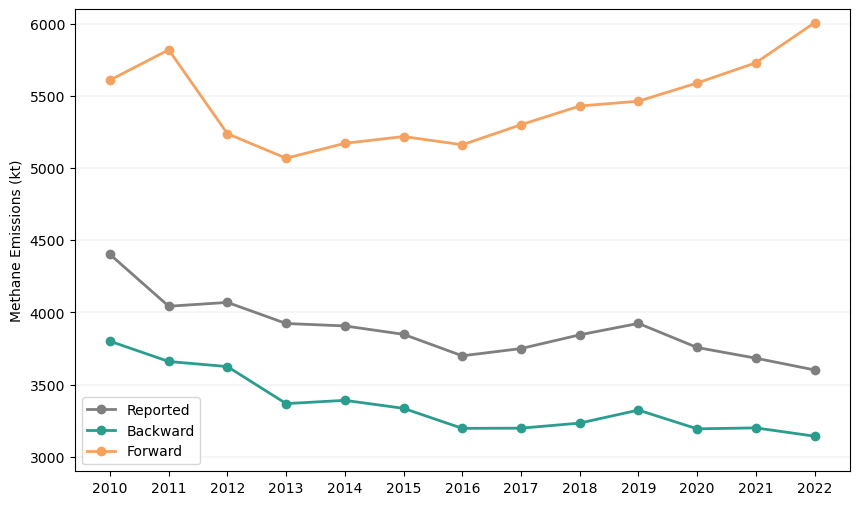

In [4]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(years, totals["Emis_Reported"], linewidth=2, color="#7f7f7f", marker="o", label="Reported")
ax.plot(years, totals["If_All_Backward"], linewidth=2, color="#2A9D8F", marker="o", label="Backward")
ax.plot(years, totals["If_All_Forward"], linewidth=2, color="#F4A261", marker="o", label="Forward")
ax.set_xticks(years)
ax.grid(axis="y", linewidth=0.15)
ax.set_ylim([2900,6100])
ax.legend()
ax.set_ylabel("Methane Emissions (kt)")
fig.savefig("figure-1.svg")

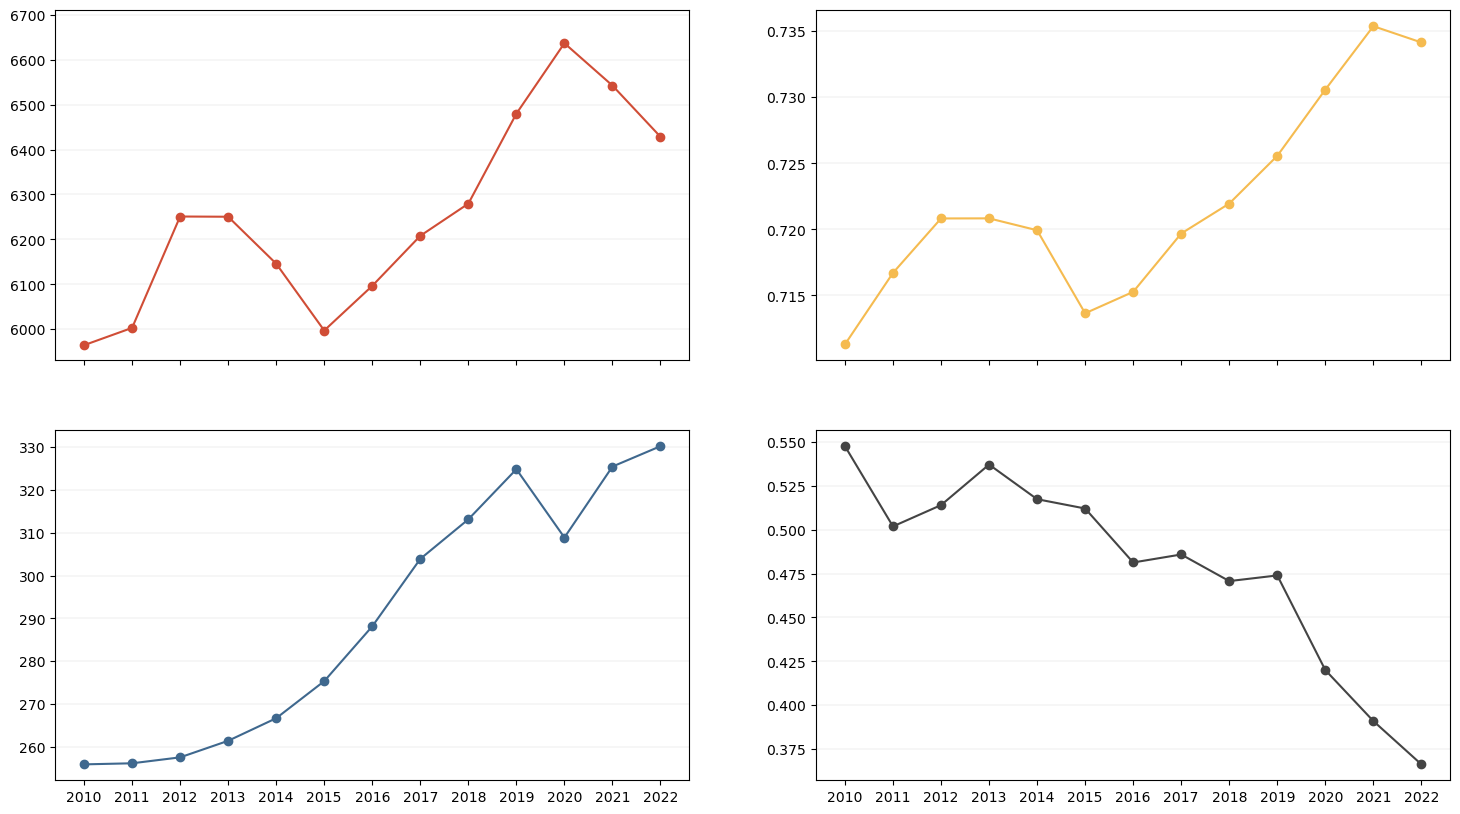

In [5]:
fig,axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(18,10))

axs[0,0].plot(years, totals["Recovered"]/1e3, marker="o", color="#d04d36")
axs[0,0].set_ylim([axs[0,0].get_ylim()[0],6710])
axs[0,1].plot(years, CE, marker="o", color="#f5bb50")
axs[1,0].plot(years, totals["Waste_Added_This_Yr"]/1e6, marker="o", color="#3f688e")
axs[1,1].plot(years, chose_higher, marker="o", color="#444444")

for ax in axs.flatten():
    ax.set_xticks(years)
    ax.grid(axis="y", linewidth=0.15)

fig.savefig("figure-2.svg")